In [1]:
import pandas as pd
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [2]:
sys.path.append('/home/khanalp/code/PhD/utils')
from utils import read_csv_file_with_station_name

In [3]:

def temperature_from_lw_out(lw_out: np.ndarray, lw_in:np.ndarray,emissivity: float) -> np.ndarray:
    """
    Calculate temperature (in Kelvin) from longwave radiation using the Stefan-Boltzmann law.

    Parameters:
        lw_out (np.ndarray or float): Outgoing longwave radiation in W/m²
        emissivity (float): Emissivity of the surface (0 < emissivity ≤ 1)

    Returns:
        np.ndarray: Temperature in Kelvin (same shape as input)
    """
    sigma = 5.670374419e-8  # W/m²/K⁴
    
    # Check emissivity is scalar and in valid range
    if not (0 < emissivity <= 1):
        raise ValueError("Emissivity must be in the range (0, 1].")
    
    lw_out = np.asarray(lw_out)
    lw_in = np.asarray(lw_in)
    if np.any(lw_out < 0):
        raise ValueError("LW_OUT values must be non-negative.")
    
    return ((lw_out -((1-emissivity) * lw_in))/ (emissivity * sigma)) ** 0.25


In [4]:
# Paths to different file
insitu_forcing = "/home/khanalp/data/processed/input_pystemmus/v2"
ICOS_location = "/home/khanalp/data/ICOS2020"
model_output_ml = "/home/khanalp/paper01/output/vMLWV/IT-MBo/v1"
model_output_bigleaf = "/home/khanalp/paper01/output/vbigleaf/IT-MBo/v1"
MODIS_LST = "/home/khanalp/paper01/output/LSTMODIS/IT-MBo_2004.csv"

In [5]:
station = "IT-MBo"
start_date = "2004-06-01 00:00:00"
end_date = "2004-08-31 23:30:00"

In [6]:
# Read forcing file
ds_forcing = xr.open_dataset(
	os.path.join(
		insitu_forcing,
		[f for f in os.listdir(insitu_forcing) if station in f][0]
	)
)

In [18]:
# Read insitu full file
df_insitu_ICOS = read_csv_file_with_station_name(ICOS_location, station)

In [7]:
ds_forcing.latitude.values, ds_forcing.longitude.values


(array([[46.01468]], dtype=float32), array([[11.045831]], dtype=float32))

In [19]:
ds_forcing.latitude.values

array([[46.01468]], dtype=float32)

In [20]:
 # Assign datetime coordinates to the 'index' dimension based on the 'TIMESTAMP_START' column
df_insitu_ICOS['time'] = pd.to_datetime(df_insitu_ICOS['TIMESTAMP_START'], format='%Y%m%d%H%M')
df_insitu_ICOS.set_index('time', inplace=True)

In [21]:
# Replace -9999 with NaN in the DataFrame
df_insitu_ICOS.replace(-9999, np.nan, inplace=True)

In [22]:
# GEt in the same duration as model run.
df_insitu_selected = df_insitu_ICOS.loc[start_date:end_date]
ds_forcing_selected = ds_forcing.sel(time=slice(start_date, end_date))

In [23]:
# Read resistances, fluxes, and other files (rac, rlcu,etc.)
df_model_ML = pd.read_csv(os.path.join(model_output_ml, "anciliary_output.csv"))
df_model_bigleaf = pd.read_csv(os.path.join(model_output_bigleaf, "anciliary_output.csv"))

In [24]:
# Read MODIS LST data
df_MODIS_LST = pd.read_csv(MODIS_LST)

In [25]:
df_MODIS_LST_filtered = df_MODIS_LST[df_MODIS_LST['LST_Day_C'].notna()]

In [26]:
from datetime import datetime, timedelta

# Helper function to convert float hours to HH:MM format
def float_to_hhmm(hour_float):
    try:
        td = timedelta(hours=hour_float)
        return (datetime.min + td).time().strftime('%H:%M')
    except:
        return None  # In case of NaN or invalid input


In [27]:
df_MODIS_LST_filtered.loc[:, 'Day_view_HHMM'] = df_MODIS_LST_filtered['Day_view_time'].apply(float_to_hhmm)
df_MODIS_LST_filtered.loc[:, 'Night_view_HHMM'] = df_MODIS_LST_filtered['Night_view_time'].apply(float_to_hhmm)


/home/khanalp/tmp/ipykernel_1329084/3262745268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MODIS_LST_filtered.loc[:, 'Day_view_HHMM'] = df_MODIS_LST_filtered['Day_view_time'].apply(float_to_hhmm)
/home/khanalp/tmp/ipykernel_1329084/3262745268.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MODIS_LST_filtered.loc[:, 'Night_view_HHMM'] = df_MODIS_LST_filtered['Night_view_time'].apply(float_to_hhmm)


In [28]:
# Step 1: Ensure 'datetime' column is datetime type
df_MODIS_LST_filtered['datetime'] = pd.to_datetime(df_MODIS_LST_filtered['datetime'])

# Step 2: Add Day_view_time (float hours) as timedelta to datetime
df_MODIS_LST_filtered['timestamp'] = df_MODIS_LST_filtered['datetime'] + pd.to_timedelta(df_MODIS_LST_filtered['Day_view_time'], unit='h')

/home/khanalp/tmp/ipykernel_1329084/4105526546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MODIS_LST_filtered['datetime'] = pd.to_datetime(df_MODIS_LST_filtered['datetime'])
/home/khanalp/tmp/ipykernel_1329084/4105526546.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MODIS_LST_filtered['timestamp'] = df_MODIS_LST_filtered['datetime'] + pd.to_timedelta(df_MODIS_LST_filtered['Day_view_time'], unit='h')


In [29]:
# Step 4: Set either one as index
df_MODIS_LST_filtered = df_MODIS_LST_filtered.set_index('timestamp')

In [30]:
df_MODIS_LST_poi = df_MODIS_LST_filtered.loc[start_date:end_date] 

In [31]:
df_model_ML = df_model_ML.apply(pd.to_numeric, errors='coerce')
df_model_bigleaf = df_model_bigleaf.apply(pd.to_numeric, errors='coerce')
df_model_ML['time'] = pd.to_datetime(ds_forcing_selected['time'].values.flatten())
df_model_bigleaf['time'] = pd.to_datetime(ds_forcing_selected['time'].values.flatten())
df_model_ML.set_index('time', inplace=True)
df_model_bigleaf.set_index('time', inplace=True)

In [32]:
# GEt LST
# COmpute LST In degree C from LW_OUT
df_insitu_selected['LST'] = temperature_from_lw_out(
    df_insitu_selected['LW_OUT'].values,
    df_insitu_selected['LW_IN_F'].values,
    emissivity=0.98
) - 273.15

/home/khanalp/tmp/ipykernel_1329084/3575629598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_insitu_selected['LST'] = temperature_from_lw_out(


In [33]:
# For each MODIS timestamp, find index of closest timestamp in model_output
closest_in_model_pos = df_model_ML.index.get_indexer(df_MODIS_LST_poi.index, method='nearest')

In [34]:
# Extract those closest model timestamps
closest_model_times = df_model_ML.index[closest_in_model_pos]

# Optionally, add this info as a column to df_MODIS_LST_poi:
df_MODIS_LST_poi['closest_model_time'] = closest_model_times
df_MODIS_LST_poi['closest_model_time'] = pd.to_datetime(df_MODIS_LST_poi['closest_model_time'])
df_MODIS_LST_poi['LST_Day_C'] = pd.to_numeric(df_MODIS_LST_poi['LST_Day_C'], errors='coerce')

/home/khanalp/tmp/ipykernel_1329084/102826905.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MODIS_LST_poi['closest_model_time'] = closest_model_times
/home/khanalp/tmp/ipykernel_1329084/102826905.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MODIS_LST_poi['closest_model_time'] = pd.to_datetime(df_MODIS_LST_poi['closest_model_time'])
/home/khanalp/tmp/ipykernel_1329084/102826905.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [50]:
df_MODIS_LST_poi

,datetime,LST_Day_C,Day_view_time,LST_Night_C,Night_view_time,Day_view_HHMM,Night_view_HHMM,closest_model_time
timestamp,,,,,,,,
2004-06-04 11:18:00,2004-06-04,21.73,11.3,NaN,NaN,11:18,None,2004-06-04 11:30:00
2004-06-08 10:54:00,2004-06-08,26.85,10.9,NaN,NaN,10:54,None,2004-06-08 11:00:00
2004-06-09 11:36:00,2004-06-09,21.09,11.6,11.39,21.1,11:36,21:06,2004-06-09 11:30:00
2004-06-10 10:42:00,2004-06-10,28.23,10.7,10.77,21.8,10:42,21:48,2004-06-10 10:30:00
2004-06-11 11:24:00,2004-06-11,25.87,11.4,NaN,NaN,11:24,None,2004-06-11 11:30:00
2004-06-13 11:12:00,2004-06-13,16.41,11.2,4.59,22.3,11:12,22:18,2004-06-13 11:00:00
2004-06-17 10:48:00,2004-06-17,23.67,10.8,9.79,21.9,10:48,21:54,2004-06-17 11:00:00
2004-06-18 11:30:00,2004-06-18,23.91,11.5,11.07,22.6,11:30,22:36,2004-06-18 11:30:00
2004-06-25 11:36:00,2004-06-25,20.79,11.6,NaN,NaN,11:36,None,2004-06-25 11:30:00


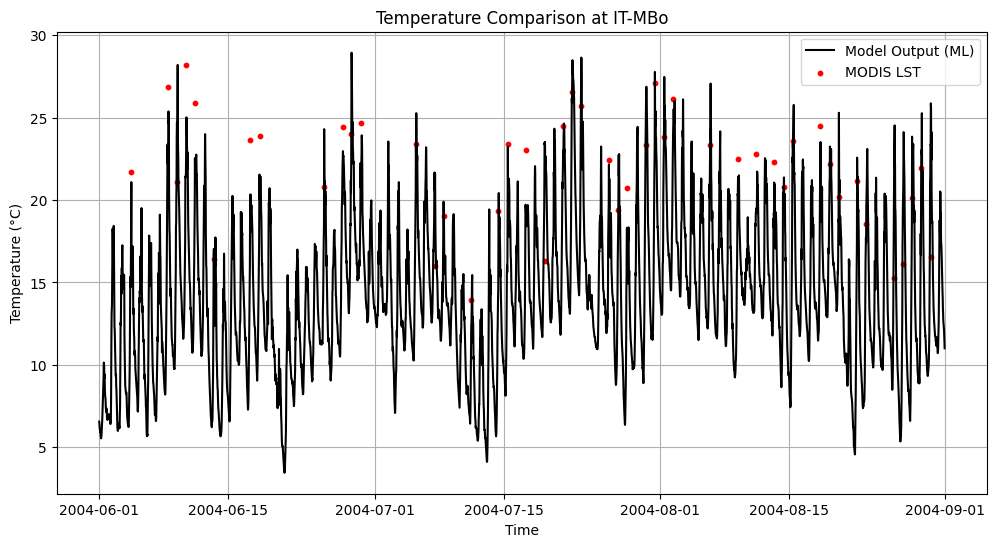

In [ ]:
plt.figure(figsize=(12, 6))
# plt.plot(df_insitu_selected.index, df_insitu_selected['LST'], label='Insitu', color = 'black')
# plt.plot(df_model_bigleaf.index, df_model_bigleaf['Tcave'], label='Model Output (bigleaf)', color = 'green')
plt.plot(df_model_ML.index, df_model_ML['Tcave'], label='Model Output (ML)', color = 'blue')
plt.plot(df_model_ML.index, df_model_ML['Tsave'], label='Model Output (ML)', color = 'black')

plt.scatter(df_MODIS_LST_poi.index, df_MODIS_LST_poi['LST_Day_C'], label='MODIS LST', color='red', s=10)
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature Comparison at {station}')
plt.legend()
plt.grid()
plt.show()

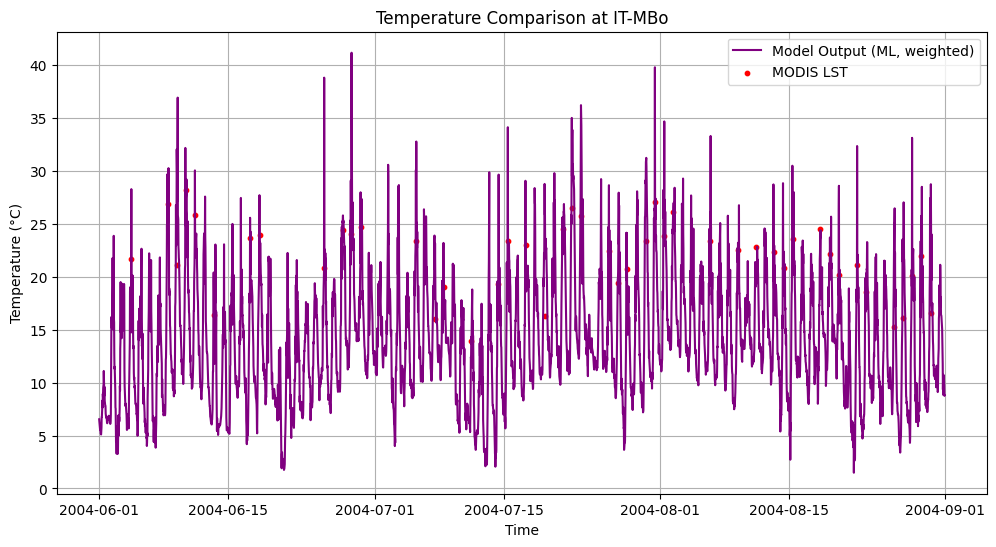

In [49]:
# Compute weighted average
df_model_ML['T_weighted'] = 0.83 * df_model_ML['Tcave'] + 0.17 * df_model_ML['Tsave']

# Plotting
plt.figure(figsize=(12, 6))

# Optional: Plot individual components for reference
# plt.plot(df_model_ML.index, df_model_ML['Tcave'], label='Tcave (ML)', color='blue', linestyle='--')
# plt.plot(df_model_ML.index, df_model_ML['Tsave'], label='Tsave (ML)', color='black', linestyle='--')

# Plot weighted average
plt.plot(df_model_ML.index, df_model_ML['T_weighted'], label='Model Output (ML, weighted)', color='purple')

# Plot MODIS LST
plt.scatter(df_MODIS_LST_poi.index, df_MODIS_LST_poi['LST_Day_C'], label='MODIS LST', color='red', s=10)

# Labels and formatting
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature Comparison at {station}')
plt.legend()
plt.grid()
plt.show()


In [42]:
# Filter df_MODIS_LST_poi to only include rows where 'closest_model_time' exists in df_model_output.index
df_matched = df_MODIS_LST_poi[df_MODIS_LST_poi['closest_model_time'].isin(df_model_ML.index)]

# Set 'closest_model_time' as the index to align with df_model_output
df_matched = df_matched.set_index('closest_model_time')

# Align both dataframes and create a new one
df_combined = pd.DataFrame({
    'Tcave_ML': df_model_ML.loc[df_matched.index, 'Tsave'],
    'Tcave_Bigleaf': df_model_bigleaf.loc[df_matched.index, 'Tsave'],
    'LST_Day_C': df_matched['LST_Day_C']
})


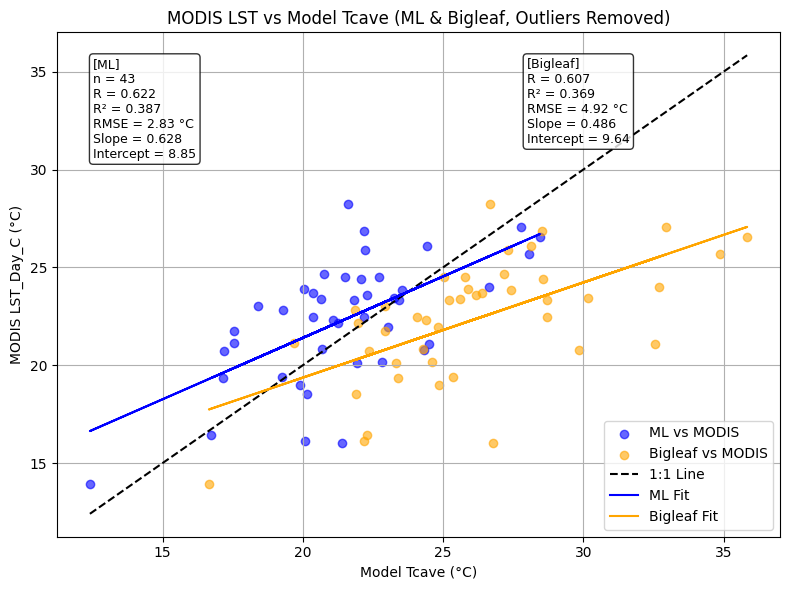

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress, pearsonr

# Step 1: Drop NaNs
df_clean = df_combined.dropna(subset=['Tcave_ML', 'Tcave_Bigleaf', 'LST_Day_C'])

# Step 2: Compute residuals for both models
df_clean['residual_ML'] = df_clean['LST_Day_C'] - df_clean['Tcave_ML']
df_clean['residual_Bigleaf'] = df_clean['LST_Day_C'] - df_clean['Tcave_Bigleaf']

# Step 3: Filter outliers (e.g., z-score < 2 for both)
z_ML = np.abs((df_clean['residual_ML'] - df_clean['residual_ML'].mean()) / df_clean['residual_ML'].std())
z_BL = np.abs((df_clean['residual_Bigleaf'] - df_clean['residual_Bigleaf'].mean()) / df_clean['residual_Bigleaf'].std())
df_filtered = df_clean[(z_ML < 2) & (z_BL < 2)]

# Extract variables
x_ml = df_filtered['Tcave_ML']
x_bl = df_filtered['Tcave_Bigleaf']
y = df_filtered['LST_Day_C']

# Stats for ML
n_ml = len(x_ml)
R_ml, _ = pearsonr(x_ml, y)
R2_ml = R_ml**2
rmse_ml = np.sqrt(mean_squared_error(y, x_ml))
slope_ml, intercept_ml, *_ = linregress(x_ml, y)

# Stats for Bigleaf
R_bl, _ = pearsonr(x_bl, y)
R2_bl = R_bl**2
rmse_bl = np.sqrt(mean_squared_error(y, x_bl))
slope_bl, intercept_bl, *_ = linregress(x_bl, y)

# Stats text
stats_text_ml = (
    f"[ML]\n"
    f"n = {n_ml}\n"
    f"R = {R_ml:.3f}\n"
    f"R² = {R2_ml:.3f}\n"
    f"RMSE = {rmse_ml:.2f} °C\n"
    f"Slope = {slope_ml:.3f}\n"
    f"Intercept = {intercept_ml:.2f}"
)

stats_text_bl = (
    f"[Bigleaf]\n"
    f"R = {R_bl:.3f}\n"
    f"R² = {R2_bl:.3f}\n"
    f"RMSE = {rmse_bl:.2f} °C\n"
    f"Slope = {slope_bl:.3f}\n"
    f"Intercept = {intercept_bl:.2f}"
)

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(x_ml, y, color='blue', alpha=0.6, label='ML vs MODIS')
plt.scatter(x_bl, y, color='orange', alpha=0.6, label='Bigleaf vs MODIS')

# 1:1 line
min_val = min(y.min(), x_ml.min(), x_bl.min())
max_val = max(y.max(), x_ml.max(), x_bl.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1 Line')

# Regression lines
plt.plot(x_ml, slope_ml * x_ml + intercept_ml, 'blue', label='ML Fit')
plt.plot(x_bl, slope_bl * x_bl + intercept_bl, 'orange', label='Bigleaf Fit')

# Labels and titles
plt.xlabel('Model Tcave (°C)')
plt.ylabel('MODIS LST_Day_C (°C)')
plt.title('MODIS LST vs Model Tcave (ML & Bigleaf, Outliers Removed)')
plt.legend()
plt.grid(True)

# Add text boxes
plt.gca().text(0.05, 0.95, stats_text_ml, transform=plt.gca().transAxes,
               fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.gca().text(0.65, 0.95, stats_text_bl, transform=plt.gca().transAxes,
               fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


In [11]:
# Read resistances, fluxes, and other files (rac, rlcu,etc.)
df_model_anciliary_bigleaf = pd.read_csv(os.path.join(model_output, base_version, station, "anciliary_output.csv"))
df_model_fluxes_bigleaf = pd.read_csv(os.path.join(model_output, base_version, station, "fluxes.csv"))
df_model_anciliary_vMLWV = pd.read_csv(os.path.join(model_output, ml_version, station, "anciliary_output.csv"))
df_model_fluxes_vMLWV = pd.read_csv(os.path.join(model_output, ml_version, station, "fluxes.csv"))
# df_model_rac = pd.read_csv(os.path.join(model_output, ml_version, station, "rac.csv"),header=None)
# df_model_rbcsh = pd.read_csv(os.path.join(model_output, ml_version, station, "rbl.csv"),header=None)
# df_model_rcwh = pd.read_csv(os.path.join(model_output,ml_version, station, "rcwh.csv"),header=None)
# df_model_Tch = pd.read_csv(os.path.join(model_output, ml_version, station, "profile_Tch.csv"),header=None)
# df_model_Tcu = pd.read_csv(os.path.join(model_output, ml_version, station, "profile_Tcu.csv"),header=None)
# df_model_Hch = pd.read_csv(os.path.join(model_output, ml_version, station, "profile_Hch.csv"),header=None)
# df_model_Hcu = pd.read_csv(os.path.join(model_output, ml_version, station, "profile_Hcu.csv"),header=None)
# df_model_Rnch = pd.read_csv(os.path.join(model_output, ml_version, station, "profile_Rnch.csv"),header=None)
# df_model_Rncu = pd.read_csv(os.path.join(model_output, ml_version, station, "profile_Rncu.csv"),header=None)
# df_model_lEch = pd.read_csv(os.path.join(model_output, ml_version, station, "profile_lEch.csv"),header=None)
# df_model_lEcu = pd.read_csv(os.path.join(model_output, ml_version, station, "profile_lEcu.csv"),header=None)
# df_model_fraction = pd.read_csv(os.path.join(model_output, ml_version, station, "fraction.csv"),header=None)



In [12]:
#Preprocessing  the model output
# Remove first row in case of fluxes
df_model_fluxes_bigleaf = df_model_fluxes_bigleaf.iloc[1:,]
df_model_fluxes_vMLWV = df_model_fluxes_vMLWV.iloc[1:,]

In [23]:
#Make everything numeric
df_model_anciliary_bigleaf = df_model_anciliary_bigleaf.apply(pd.to_numeric, errors='coerce')
df_model_anciliary_vMLWV = df_model_anciliary_vMLWV.apply(pd.to_numeric, errors='coerce')
df_model_fluxes_bigleaf = df_model_fluxes_bigleaf.apply(pd.to_numeric, errors='coerce')
df_model_fluxes_vMLWV = df_model_fluxes_vMLWV.apply(pd.to_numeric, errors='coerce')
# df_model_rac = df_model_rac.apply(pd.to_numeric, errors='coerce')
# df_model_rbcsh = df_model_rbcsh.apply(pd.to_numeric, errors='coerce')
# df_model_rcwh = df_model_rcwh.apply(pd.to_numeric, errors='coerce')
# df_model_Tch = df_model_Tch.apply(pd.to_numeric, errors='coerce')
# df_model_Tcu = df_model_Tcu.apply(pd.to_numeric, errors='coerce')
# df_model_Hch = df_model_Hch.apply(pd.to_numeric, errors='coerce')
# df_model_Hcu = df_model_Hcu.apply(pd.to_numeric, errors='coerce')
# df_model_Rnch = df_model_Rnch.apply(pd.to_numeric, errors='coerce')
# df_model_Rncu = df_model_Rncu.apply(pd.to_numeric, errors='coerce')
# df_model_lEch = df_model_lEch.apply(pd.to_numeric, errors='coerce')
# df_model_lEcu = df_model_lEcu.apply(pd.to_numeric, errors='coerce')
# df_model_fraction  = df_model_fraction.apply(pd.to_numeric, errors='coerce')

In [14]:
# Add time column to the DataFrames and make it index 
df_model_anciliary_bigleaf['time'] = pd.to_datetime(ds_forcing_selected['time'].values.flatten())
df_model_anciliary_vMLWV['time'] = pd.to_datetime(ds_forcing_selected['time'].values.flatten())
df_model_fluxes_bigleaf['time'] = pd.to_datetime(ds_forcing_selected['time'].values.flatten())
df_model_fluxes_vMLWV['time'] = pd.to_datetime(ds_forcing_selected['time'].values.flatten())



In [15]:
# Set time as index
df_model_anciliary_bigleaf.set_index('time', inplace=True)
df_model_anciliary_vMLWV.set_index('time', inplace=True)
df_model_fluxes_bigleaf.set_index('time', inplace=True)
df_model_fluxes_vMLWV.set_index('time', inplace=True)

In [16]:
# GEt LST
# COmpute LST In degree C from LW_OUT
df_insitu_selected['LST'] = temperature_from_lw_out(
    df_insitu_selected['LW_OUT'].values,
    df_insitu_selected['LW_IN_F'].values,
    emissivity=0.98
) - 273.15

/home/khanalp/tmp/ipykernel_1145603/3575629598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_insitu_selected['LST'] = temperature_from_lw_out(


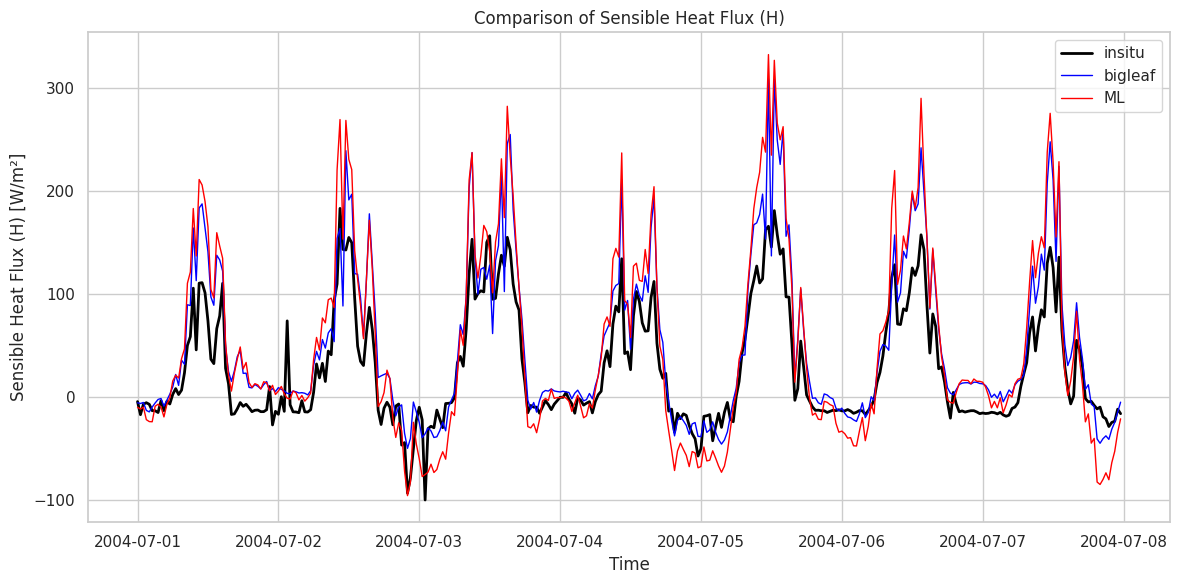

In [35]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.plot(df_insitu_selected.index, df_insitu_selected.H_F_MDS, label='insitu', color='black', linewidth=2)
plt.plot(df_model_fluxes_bigleaf.index, df_model_fluxes_bigleaf.Htot, label='bigleaf', color='blue', linewidth=1, linestyle='-')
# plt.plot(df_model_fluxes_bigleaf.index, df_model_fluxes_bigleaf.Hctot, label='bigleaf', color='blue', linewidth=1)
plt.plot(df_model_fluxes_vMLWV.index, df_model_fluxes_vMLWV.Htot, label='ML', color='red', linewidth=1)
# plt.plot(df_model_fluxes_vMLWV.index, df_model_fluxes_vMLWV.Hctot, label='ML', color='red', linewidth=1)

plt.xlabel('Time')
plt.ylabel('Sensible Heat Flux (H) [W/m²]')
plt.title('Comparison of Sensible Heat Flux (H)')
plt.legend()
plt.tight_layout()
plt.show()



/home/khanalp/tmp/ipykernel_1145603/316799082.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_insitu_selected['hour'] = df_insitu_selected.index.hour


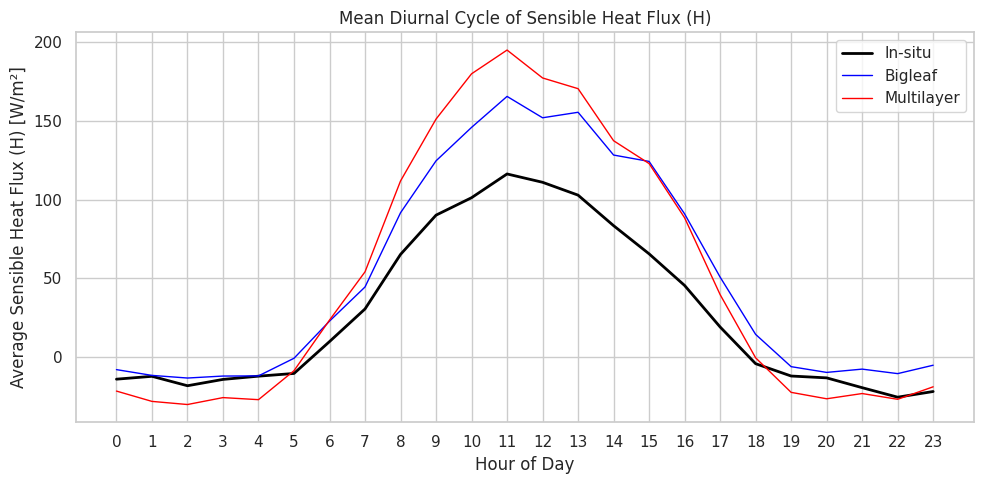

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Create 'hour' column if not already present
df_insitu_selected['hour'] = df_insitu_selected.index.hour
df_model_fluxes_bigleaf['hour'] = df_model_fluxes_bigleaf.index.hour
df_model_fluxes_vMLWV['hour'] = df_model_fluxes_vMLWV.index.hour

# Step 2: Compute mean diurnal cycle
diurnal_insitu = df_insitu_selected.groupby('hour')['H_F_MDS'].mean()
diurnal_bigleaf = df_model_fluxes_bigleaf.groupby('hour')['Htot'].mean()
diurnal_ML = df_model_fluxes_vMLWV.groupby('hour')['Htot'].mean()

# Step 3: Plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))

plt.plot(diurnal_insitu.index, diurnal_insitu.values, label='In-situ', color='black', linewidth=2)
plt.plot(diurnal_bigleaf.index, diurnal_bigleaf.values, label='Bigleaf', color='blue', linewidth=1)
plt.plot(diurnal_ML.index, diurnal_ML.values, label='Multilayer', color='red', linewidth=1)

plt.xlabel('Hour of Day')
plt.ylabel('Average Sensible Heat Flux (H) [W/m²]')
plt.title('Mean Diurnal Cycle of Sensible Heat Flux (H)')
plt.xticks(range(0, 24))
plt.legend()
plt.tight_layout()
plt.show()


### Plotting Fluxes

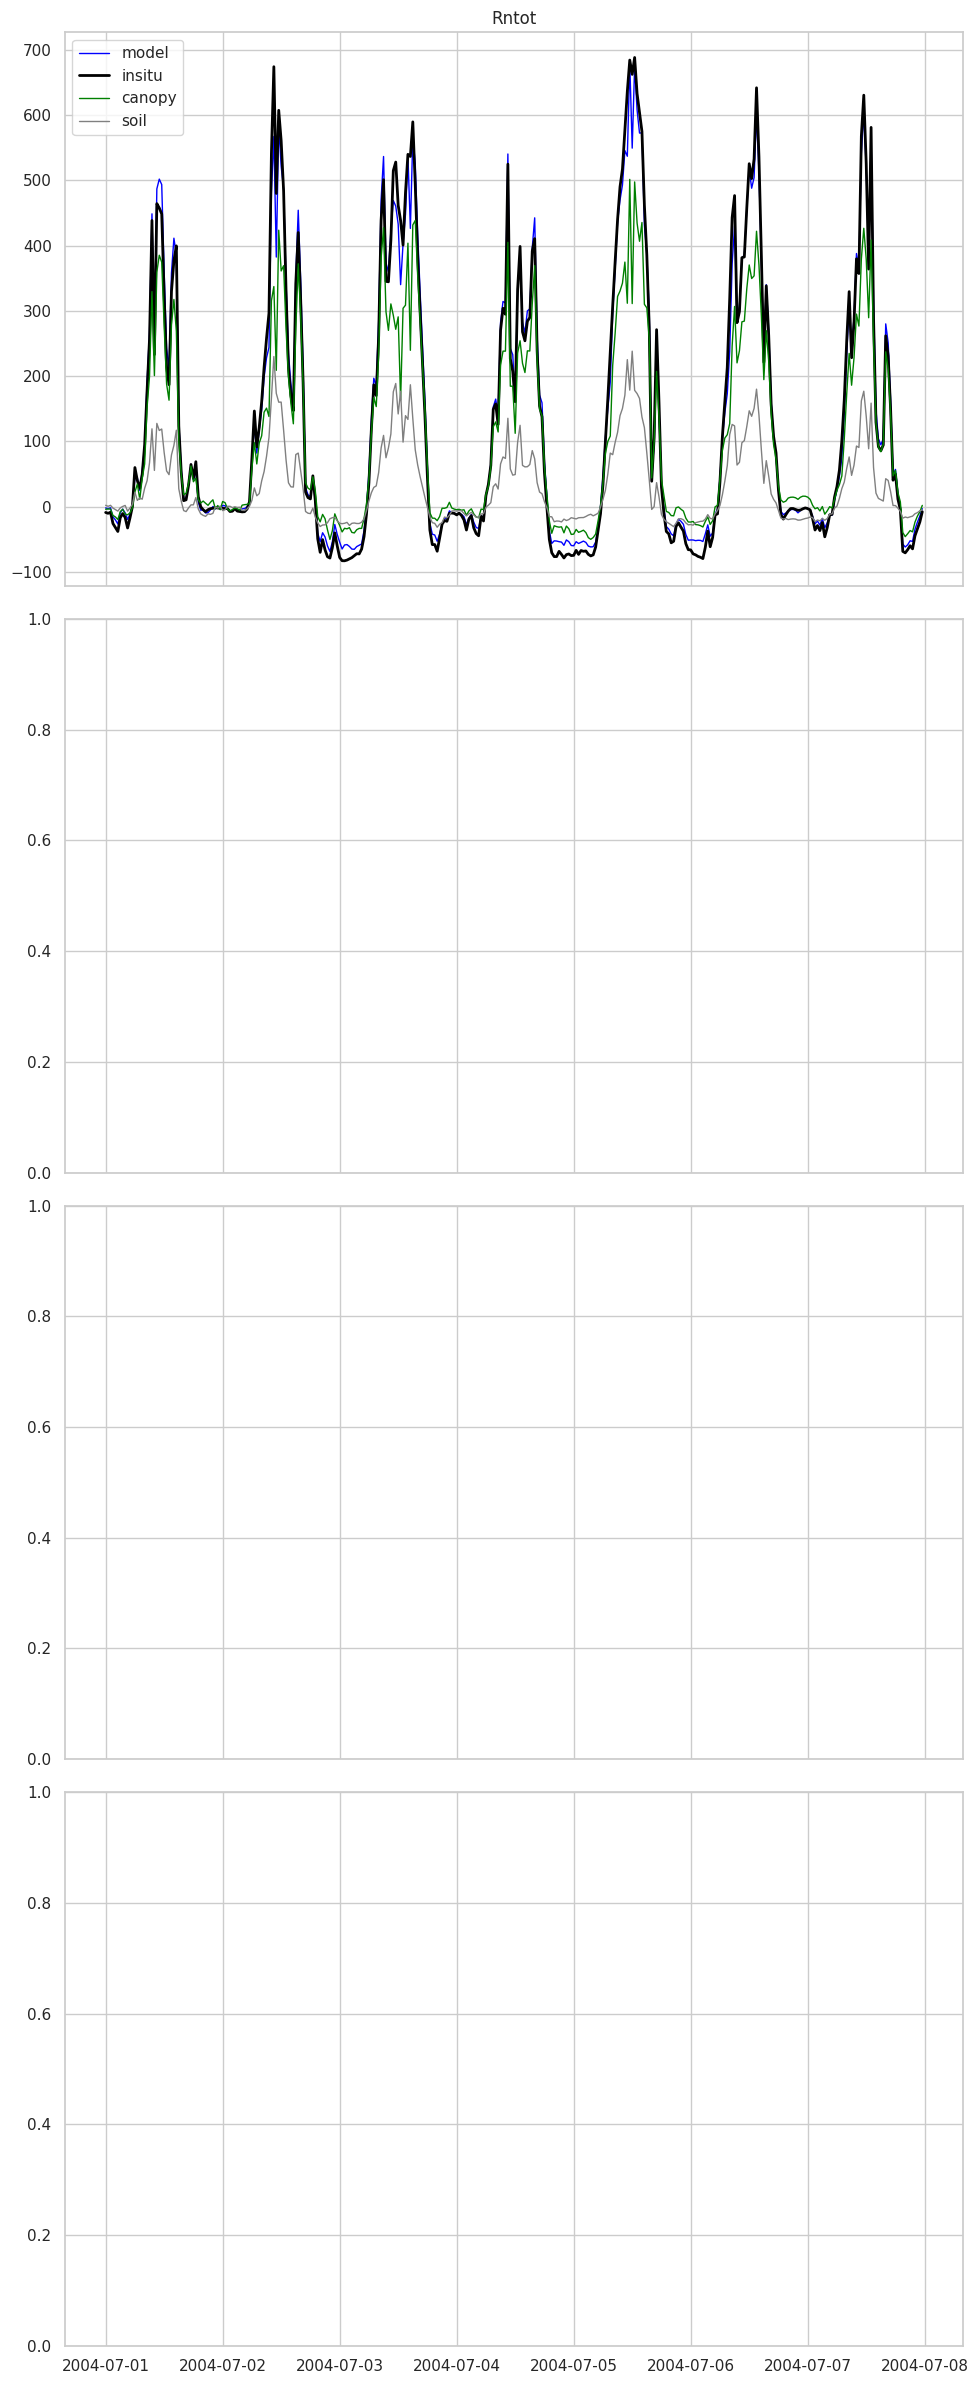

In [ ]:
# # Set publication-style aesthetics
# sns.set_theme(style="whitegrid")
# fig, axs = plt.subplots(4, 1, figsize=(10, 24), sharex=True)

# # Plot 1: Rntot
# # axs[0].plot(df_fluxes_base_poi.index, df_fluxes_base_poi.Rntot, label='base', color='red', linewidth=1.5)
# axs[0].plot(df_model_fluxes_bigleaf.index, df_model_fluxes_bigleaf.Rntot, label='model', color='blue', linewidth=1)
# axs[0].plot(df_insitu_selected.index, df_insitu_selected.NETRAD, label='insitu', color='black', linewidth=2)
# axs[0].plot(df_model_fluxes_bigleaf.index, df_model_fluxes_bigleaf.Rnctot, label='canopy', color='green', linewidth=1)
# axs[0].plot(df_model_fluxes_bigleaf.index, df_model_fluxes_bigleaf.Rnstot, label='soil', color='grey', linewidth=1)
# axs[0].set_title('Rntot')
# axs[0].legend()

# # Plot 2: Htot
# axs[1].plot(df_model_fluxes.index, df_model_fluxes.Htot, label='model', color='blue', linewidth=1)
# axs[1].plot(df_insitu_selected.index, df_insitu_selected.H_F_MDS, label='insitu', color='black', linewidth=2)
# axs[1].plot(df_model_fluxes.index, df_model_fluxes.Hctot, label='canopy', color='green', linewidth=1)
# axs[1].plot(df_model_fluxes.index, df_model_fluxes.Hstot, label='soil', color='grey', linewidth=1)
# axs[1].set_title('Htot')
# axs[1].legend()

# # # Plot 3: lEtot
# # axs[2].plot(df_model_fluxes.index, df_model_fluxes.lEtot, label='model', color='blue', linewidth=1)
# # axs[2].plot(df_insitu_selected.index, df_insitu_selected.LE_F_MDS, label='insitu', color='black', linewidth=2)
# # axs[2].plot(df_model_fluxes.index, df_model_fluxes.lEctot, label='canopy', color='green', linewidth=1)
# # axs[2].plot(df_model_fluxes.index, df_model_fluxes.lEstot, label='soil', color='grey', linewidth=1)
# # axs[2].set_title('LEtot')
# # axs[2].legend()

# # # Plot 4: Gtot
# # axs[3].plot(df_model_fluxes.index, df_model_fluxes.Gtot, label='model', color='blue', linewidth=1)
# # axs[3].plot(df_insitu_selected.index, df_insitu_selected.G_F_MDS, label='insitu', color='black', linewidth=2)
# # axs[3].set_title('Gtot')
# # axs[3].legend()

# # Adjust layout
# plt.tight_layout()
# plt.show()


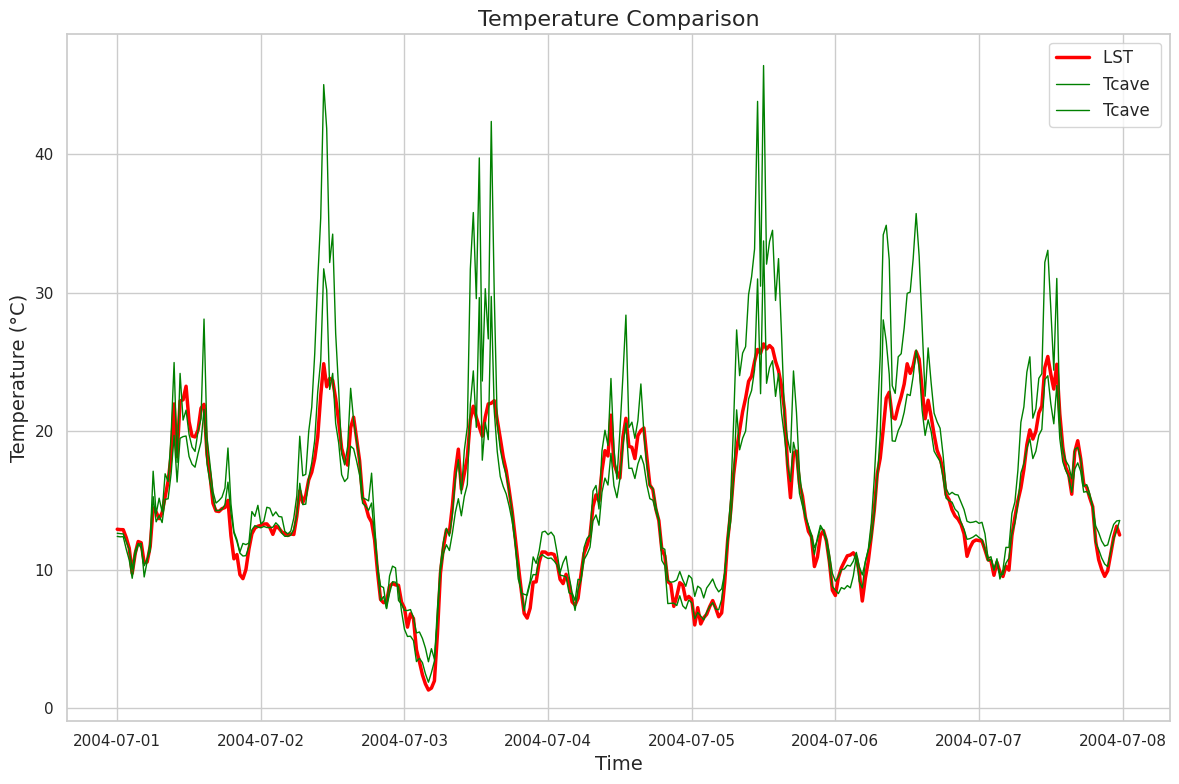

In [37]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot each variable
plt.plot(df_insitu_selected.index, df_insitu_selected['LST'], label='LST ', color='red', linewidth=2.5)
# plt.plot(df_insitu_selected.index, df_insitu_selected['TA_F_MDS'], label='Tair ', color='black', linewidth=2.5)
# plt.plot(df_model_ancilliary.index, df_model_ancilliary['Tsh'], label='Tsh (soil) ', color='blue', linewidth=1)
# plt.plot(df_model_ancilliary.index, df_model_ancilliary['Tsu'], label='Tsu (soil) ', color='orange', linewidth=1)
plt.plot(df_model_anciliary_bigleaf.index, df_model_anciliary_bigleaf['Tcave'], label='Tcave ', color='green', linewidth=1)
plt.plot(df_model_anciliary_vMLWV.index, df_model_anciliary_vMLWV['Tcave'], label='Tcave ', color='green', linewidth=1)

# Add labels, legend, and title
plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.title('Temperature Comparison', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

/home/khanalp/tmp/ipykernel_1145603/1907492126.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_insitu_selected['hour'] = df_insitu_selected.index.hour


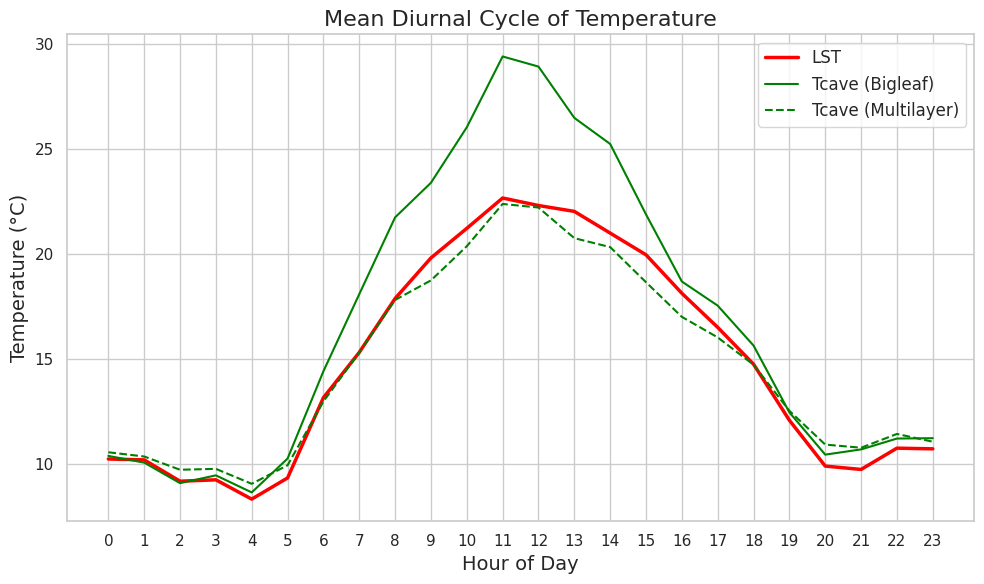

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Add 'hour' column
df_insitu_selected['hour'] = df_insitu_selected.index.hour
df_model_anciliary_bigleaf['hour'] = df_model_anciliary_bigleaf.index.hour
df_model_anciliary_vMLWV['hour'] = df_model_anciliary_vMLWV.index.hour

# Step 2: Compute diurnal means
diurnal_lst = df_insitu_selected.groupby('hour')['LST'].mean()
# diurnal_tair = df_insitu_selected.groupby('hour')['TA_F_MDS'].mean()
# diurnal_tsh = df_model_ancilliary.groupby('hour')['Tsh'].mean()
# diurnal_tsu = df_model_ancilliary.groupby('hour')['Tsu'].mean()
diurnal_tcave_bigleaf = df_model_anciliary_bigleaf.groupby('hour')['Tcave'].mean()
diurnal_tcave_ml = df_model_anciliary_vMLWV.groupby('hour')['Tcave'].mean()

# Step 3: Plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

plt.plot(diurnal_lst.index, diurnal_lst.values, label='LST', color='red', linewidth=2.5)
# plt.plot(diurnal_tair.index, diurnal_tair.values, label='Tair', color='black', linewidth=2.5)
# plt.plot(diurnal_tsh.index, diurnal_tsh.values, label='Tsh (soil)', color='blue', linewidth=1)
# plt.plot(diurnal_tsu.index, diurnal_tsu.values, label='Tsu (soil)', color='orange', linewidth=1)
plt.plot(diurnal_tcave_bigleaf.index, diurnal_tcave_bigleaf.values, label='Tcave (Bigleaf)', color='green', linewidth=1.5, linestyle='-')
plt.plot(diurnal_tcave_ml.index, diurnal_tcave_ml.values, label='Tcave (Multilayer)', color='green', linewidth=1.5, linestyle='--')

# Add labels and legend
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.title('Mean Diurnal Cycle of Temperature', fontsize=16)
plt.xticks(range(0, 24))
plt.legend(fontsize=12)
plt.grid(True)

# Final layout
plt.tight_layout()
plt.show()


In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot each variable with labels and colors
plt.plot(df_model_ancilliary.index, df_model_ancilliary.Rnssh, label='Rnssh', color='red', linewidth=1.5)
plt.plot(df_model_ancilliary.index, df_model_ancilliary.Hssh, label='Hssh', color='green', linewidth=1.5)
plt.plot(df_model_ancilliary.index, df_model_ancilliary.lEssh, label='lEssh', color='blue', linewidth=1.5)
plt.plot(df_model_ancilliary.index, df_model_ancilliary.Gssh, label='Gssh', color='grey', linewidth=1.5)

# Add labels, legend, and title
plt.xlabel('Time', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Energy balance component shaded part', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot each variable with labels and colors
plt.plot(df_model_ancilliary.index, df_model_ancilliary.Rnssu, label='Rnssu', color='red', linewidth=1.5)
plt.plot(df_model_ancilliary.index, df_model_ancilliary.Hssu, label='Hssu', color='green', linewidth=1.5)
plt.plot(df_model_ancilliary.index, df_model_ancilliary.lEssu, label='lEssu', color='blue', linewidth=1.5)
plt.plot(df_model_ancilliary.index, df_model_ancilliary.Gssu, label='Gssu', color='grey', linewidth=1.5)

# Add labels, legend, and title
plt.xlabel('Time', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Energy balance component sunlit part', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot each variable with labels and colors
plt.plot(df_model_ancilliary.index, df_model_ancilliary.Fsh, label='Fraction', color='red', linewidth=1.5)


# Add labels, legend, and title
plt.xlabel('Time', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Fraction of shaded part', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot each variable with labels and colors
plt.plot(df_model_ancilliary.index, df_model_ancilliary.LAI, label='Fraction', color='red', linewidth=1.5)


# Add labels, legend, and title
plt.xlabel('Time', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Fraction of shaded part', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
df_model_rbcsh.iloc[0,:].plot()
# df_model_rac.iloc[0,:].plot()
# df_model_rbcsh.iloc[0,:].plot()
# df_model_rac.iloc[0,:].plot()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

def plot_lad_beta(p: float, q: float, lad_max: float = 1.0) -> None:
    """
    Plot Leaf Area Density (LAD) as a Beta distribution function.

    Parameters:
    - p (float): shape parameter α of the beta distribution.
    - q (float): shape parameter β of the beta distribution.
    - lad_max (float): maximum LAD value to scale the PDF.
    """
    z_h = np.linspace(0, 1, 300)
    lad = lad_max * beta.pdf(z_h, p, q)

    plt.figure(figsize=(6, 8))
    plt.plot(lad, z_h, color='forestgreen', linewidth=2)
    plt.xlabel('Leaf Area Density (m²/m³)', fontsize=12)
    plt.ylabel('Normalized height (z/h)', fontsize=12)
    plt.title(f'LAD Profile: Beta Distribution (p={p}, q={q})', fontsize=14)
    plt.grid(True)
    plt.gca().invert_yaxis()  # Optional: z/h from 1 (top) to 0 (ground)
    plt.tight_layout()
    plt.show()

# Example usage
plot_lad_beta(p=2, q=5)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

def plot_lad_beta(p: float, q: float, lad_max: float = 1.0) -> None:
    """
    Plot Leaf Area Density (LAD) as a Beta distribution function.

    Parameters:
    - p (float): shape parameter α of the beta distribution.
    - q (float): shape parameter β of the beta distribution.
    - lad_max (float): maximum LAD value to scale the PDF.
    """
    z_h = np.linspace(0, 1, 300)
    lad = lad_max * beta.pdf(z_h, p, q)

    plt.figure(figsize=(6, 8))
    plt.plot(lad, z_h, color='forestgreen', linewidth=2)
    plt.xlabel('Leaf Area Density (m²/m³)', fontsize=12)
    plt.ylabel('Normalized height (z/h)', fontsize=12)
    plt.title(f'LAD Profile: Beta Distribution (p={p}, q={q})', fontsize=14)
    plt.grid(True)
    plt.gca().invert_yaxis()  # Optional: z/h from 1 (top) to 0 (ground)
    plt.tight_layout()
    plt.show()

# Example usage
plot_lad_beta(p=2, q=5)


In [ ]:
selected_idx = df_model_ancilliary.index.get_loc(selected_time)

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(6, 16), sharey=True)
axes = axes.flatten()

# List of variable base names and their labels
var_list = [
    # ('rac', 'Aerodynamic Resistance'),
    # ('rbl', 'Boundary Layer Resistance'),
    ('Tch', 'Canopy Temperature'),
    ('Tcu', 'Understory Temperature'),
    ('Hch', 'Canopy Sensible Heat'),
    ('Hcu', 'Understory Sensible Heat'),
    ('Rnch', 'Canopy Net Radiation'),
    ('Rncu', 'Understory Net Radiation'),
    ('lEch', 'Canopy Latent Heat'), 
    ('lEcu', 'Understory Latent Heat'),
]

# Only plot pairs (_ch and _cu) together
for i in range(4):
    base, label = var_list[2*i][0][:-2], var_list[2*i][1].split()[0]
    df_ch = globals()[f'df_model_{base}ch']
    df_cu = globals()[f'df_model_{base}cu']
    axes[i].plot(df_ch.iloc[:, selected_idx], df_ch.index, marker='o', label=f'{base}_ch', color='blue')
    axes[i].plot(df_cu.iloc[:, selected_idx], df_cu.index, marker='o', label=f'{base}_cu', color='orange')
    axes[i].set_ylabel('Vertical Level (0 at bottom)', fontsize=13)
    axes[i].set_xlabel(label, fontsize=13)
    axes[i].set_title(f'{label} Profile at {selected_time}', fontsize=15)
    axes[i].legend(fontsize=12)
    axes[i].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 6))

plt.plot(df_model_rac.iloc[:, selected_idx], df_model_rac.index[::-1], marker='o', label='Aerodynamic Resistance', color='blue', linewidth=2)
plt.plot(df_model_rbl.iloc[:, selected_idx], df_model_rbl.index[::-1], marker='o', label='Boundary Layer Resistance', color='orange', linewidth=2)

plt.xlabel('Resistance (s m$^{-1}$)', fontsize=14)
plt.ylabel('Vertical Level (0 at bottom)', fontsize=14)
plt.title('Aerodynamic and Boundary Layer Resistance Profile\nat {}'.format(selected_time.strftime('%Y-%m-%d %H:%M')), fontsize=15)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 6))

plt.plot(df_model_fraction.iloc[:, selected_idx], df_model_fraction.index[::-1], marker='o', label='Fraction of shaded part', color='blue', linewidth=2)


plt.xlabel('Fraction', fontsize=14)
plt.ylabel('Vertical Level (0 at bottom)', fontsize=14)
plt.title('Fraction of shaded part {}'.format(selected_time.strftime('%Y-%m-%d %H:%M')), fontsize=15)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
Tch = df_model_Tch.iloc[:, selected_idx].values

In [ ]:
Tch

In [ ]:
df_model_Tch.iloc[:, selected_idx] 